In [ ]:
import requests
import json
import pandas as pd

In [ ]:
ticker = "AAPL"
url = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=' + ticker + '&apikey=demo'
r = requests.get(url)
data = r.json()

print(data)

In [ ]:
data_str = json.dumps(data, indent=4)
print(data_str)

In [ ]:
df = pd.DataFrame()
relevances = []
sentiment_scores = []
sentiment_index = data["sentiment_score_definition"]
print(sentiment_index)
for article in data['feed']:
  for tick in article['ticker_sentiment']:
    if tick['ticker'] == ticker:
      relevances.append(float(tick['relevance_score']))
      sentiment_scores.append(float(tick['ticker_sentiment_score']))
df['Relevances'] = relevances
df['Sentiments'] = sentiment_scores
avg_sentiment = ((df['Relevances']*df['Sentiments']).sum())/(df['Relevances'].sum())
if avg_sentiment <= -0.35:
  print("Bearish")
elif -0.35 < avg_sentiment <= -0.15:
  print("Somewhat Bearish")
elif -0.15 < avg_sentiment < 0.15:
  print("Neutral")
elif 0.15 <= avg_sentiment < 0.35:
  print("Somewhat Bullish")
else:
  print("Bullish")

print(avg_sentiment)



In [ ]:
import IPython
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import os
import datetime
import tensorflow as tf


data = pd.read_csv("weekly_adjusted_IBM.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d')
data = data.drop(index=0)

data.describe().transpose()
data.index = data['timestamp']
timestamps = data['timestamp'].copy().to_frame()
del data['timestamp']
#del data['dividend amount']
data.head()

In [ ]:
i = int(len(data)*0.1)
j = int(len(data)*0.3)
test = data[0:i]
val = data[i:j]
train = data[j:]

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train, val_df=val, test_df=test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices. (Not needed, data is already indexed)
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

data.head()

In [ ]:
w1 = WindowGenerator(input_width=10, label_width=4, shift=1, label_columns=['adjusted close'])
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.

example_window = tf.stack([np.array(train[:w1.total_window_size]),
                           np.array(train[100:100+w1.total_window_size]),
                           np.array(train[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
w1.example = example_inputs, example_labels
def plot(self, model=None, plot_col='adjusted close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
w1.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
wide_window = WindowGenerator(input_width=8, label_width=8, shift=1,label_columns=['adjusted close'])

In [ ]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
MAX_EPOCHS = 50
lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(256, return_sequences=True),
                                         tf.keras.layers.LSTM(128, return_sequences=True),
                                         tf.keras.layers.LSTM(64, return_sequences=True),
                                         tf.keras.layers.LSTM(64, return_sequences=True),
                                         tf.keras.layers.Dense(units=8, activation='relu'),
                                         tf.keras.layers.Dense(units=1, activation='linear')])
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = lstm_model.evaluate(wide_window.val)
performance = lstm_model.evaluate(wide_window.test, verbose=0)

8/8 [==============================] - 0s 21ms/step - loss: 1170.8367 - mean_absolute_error: 32.6106


In [ ]:
losses = pd.DataFrame(history.history)
sns.lineplot(losses)
wide_window.plot(lstm_model)
inputs, labels = wide_window.example
predictions = lstm_model([inputs])
#wide_window.plot(lstm_model)

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
multi_window.plot()

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

7/7 [==============================] - 0s 5ms/step - loss: 78502732759040.0000 - mean_absolute_error: 5330931.0000


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 4 of dimension 2 out of bounds. [Op:StridedSlice] name: strided_slice/

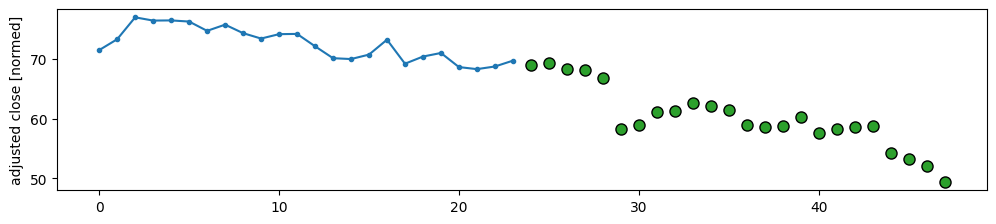

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

In [ ]:
#test, train = np.split(data, [int(.25*len(data))])
#data_np = data['adjusted close'].to_numpy()
#X = []
#y = []

#for i in range(len(data_np) - 4):
#  row = [a for a in data_np[i:i + 4]]
#  X.append(row)
#  label = data_np[i + 4]
#  y.append(label)

#X = np.array(X)
#y = np.array(y)

#split1 = int(.10*len(data))
#split2 = int(.30*len(data))
#X_test, y_test = X[:split1], y[:split1]
#X_val, y_val = X[split1:split2], y[split1:split2]
#X_train, y_train = X[split2:], y[split2:]

#print(y_test[:10])

In [ ]:
#from tensorflow.keras.models import Sequential, save_model, load_model
#from tensorflow.keras.layers import *
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.losses import MeanSquaredError
#from tensorflow.keras.metrics import RootMeanSquaredError
#from tensorflow.keras.optimizers import Adam

In [ ]:
#model_1 = Sequential()

#model_1.add(InputLayer((4, 1)))
#model_1.add(LSTM(100, return_sequences = True))
#model_1.add(LSTM(100, return_sequences = True))
#model_1.add(LSTM(50))
#model_1.add(Dense(8, activation = 'relu'))
#model_1.add(Dense(1, activation = 'linear'))

#model_1.summary()

In [ ]:
#early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

#model_1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.04), metrics = RootMeanSquaredError())

#model_1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, callbacks = [])

In [ ]:
#losses = pd.DataFrame(model_1.history.history)

#sns.lineplot(losses)

In [ ]:
#test_pred = model_1.predict(X_test).flatten()
#X_data = []
#for i in X_test:
#  X_data.append(i[0])
#df = pd.DataFrame({'Test':X_data,'Predictions':test_pred})
#sns.lineplot(df)